In [15]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models


In [16]:
train_df = pd.read_csv("train2.csv")
train_df.head()


,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


Set Parameters

In [17]:
IMAGE_SIZE = 128  # smaller size to save memory
BATCH_SIZE = 8    # small batch to avoid crashing
EPOCHS = 5        # fewer epochs to test first
TRAIN_DIR = "train_images"  # path to images


### Parse Row Function

In [18]:


def parse_row(image_id, bbox, width, height):
    # Convert from tensor to Python
    image_id = image_id.numpy().decode('utf-8')
    bbox = bbox.numpy().decode('utf-8')
    width = int(width.numpy())
    height = int(height.numpy())

    # Load image
    img_path = os.path.join(TRAIN_DIR, image_id + ".jpg")
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = img / 255.0  # normalize

    # Convert bbox to YOLO format
    x, y, w, h = eval(bbox)
    x_center = (x + w/2) / width
    y_center = (y + h/2) / height
    w_norm = w / width
    h_norm = h / height

    return img.astype(np.float32), np.array([x_center, y_center, w_norm, h_norm], dtype=np.float32)


### TensorFlow Dataset Parser

In [19]:
def tf_parse(image_id, bbox, width, height):
    img, box = tf.py_function(parse_row,
                               [image_id, bbox, width, height],
                               [tf.float32, tf.float32])
    img.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    box.set_shape([4])
    return img, box


### Create Dataset

In [20]:
dataset = tf.data.Dataset.from_tensor_slices(
    (train_df['image_id'], train_df['bbox'], train_df['width'], train_df['height'])
)

dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(512).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


### Build the Model

In [21]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='sigmoid')  # x_center, y_center, w, h
])

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,100 (24.86 MB)

 Trainable params: 6,516,100 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [22]:
history = model.fit(dataset, epochs=EPOCHS)


Epoch 1/5
18475/18475 ━━━━━━━━━━━━━━━━━━━━ 1860s 101ms/step - loss: 0.0437
Epoch 2/5
18475/18475 ━━━━━━━━━━━━━━━━━━━━ 11113s 601ms/step - loss: 0.0436
Epoch 3/5
18475/18475 ━━━━━━━━━━━━━━━━━━━━ 1897s 103ms/step - loss: 0.0436
Epoch 4/5
18475/18475 ━━━━━━━━━━━━━━━━━━━━ 1885s 102ms/step - loss: 0.0436
Epoch 5/5
18475/18475 ━━━━━━━━━━━━━━━━━━━━ 1799s 97ms/step - loss: 0.0436


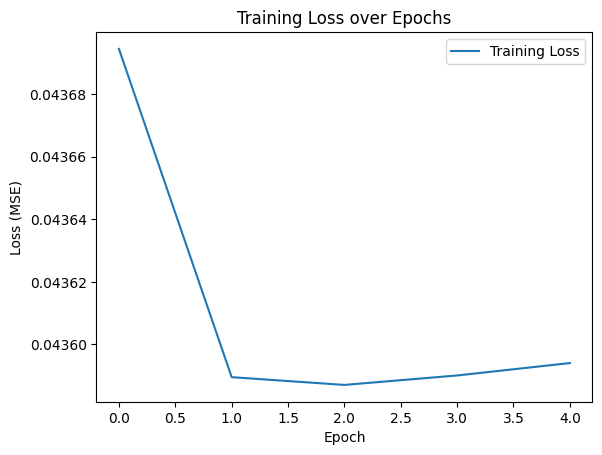

In [26]:
# Plot training loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


### Evaluate & Visualize Predictions

In [29]:
TEST_DIR = "test_images"  # path to your test images
test_df = pd.DataFrame({'image_id': os.listdir(TEST_DIR)})

def parse_test_row(image_id):
    """Load and preprocess test image (no bbox needed)"""
    image_id = image_id.numpy().decode('utf-8')
    img_path = os.path.join(TEST_DIR, image_id)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = img / 255.0
    return img.astype(np.float32)

def tf_parse_test(image_id):
    img = tf.py_function(parse_test_row, [image_id], tf.float32)
    img.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    return img

# Create test dataset
test_dataset = tf.data.Dataset.from_tensor_slices(test_df['image_id'])
test_dataset = test_dataset.map(tf_parse_test, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [30]:
# Take the first batch of test images and predict
for images in test_dataset.take(1):
    preds = model.predict(images)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


In [31]:
def yolo_to_pixel(box, img_shape):
    """Convert normalized YOLO bbox to pixel coordinates"""
    h, w, _ = img_shape
    x_center, y_center, bw, bh = box
    x1 = int((x_center - bw/2) * w)
    y1 = int((y_center - bh/2) * h)
    x2 = int((x_center + bw/2) * w)
    y2 = int((y_center + bh/2) * h)
    return x1, y1, x2, y2


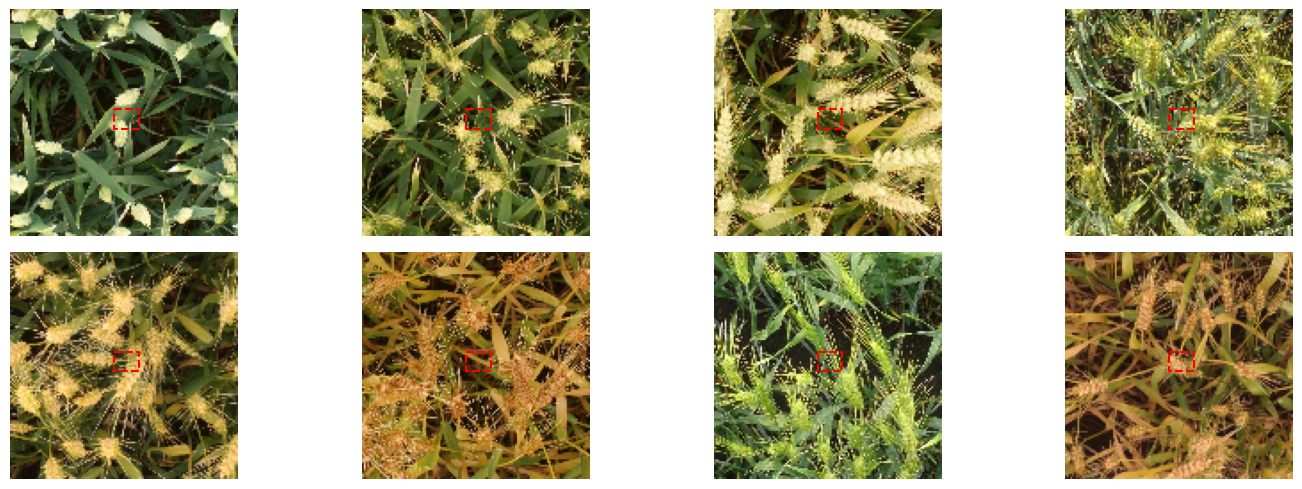

In [32]:
plt.figure(figsize=(15,5))
for i in range(len(images)):
    img = images[i].numpy()
    pred_box = preds[i]
    x1, y1, x2, y2 = yolo_to_pixel(pred_box, img.shape)
    
    plt.subplot(2, BATCH_SIZE//2, i+1)
    plt.imshow(img)
    plt.plot([x1, x2, x2, x1, x1],
             [y1, y1, y2, y2, y1],
             'r--', label='Pred Box')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [33]:
all_preds = []       # List to store predictions
all_image_ids = []   # List to store corresponding image IDs

for batch in test_dataset:
    images = batch
    preds = model.predict(images)
    all_preds.extend(preds)

# Get all image IDs from test_df
all_image_ids = test_df['image_id'].tolist()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


In [34]:
def yolo_to_pixel(box, img_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)):
    """Convert normalized YOLO bbox to pixel coordinates"""
    h, w, _ = img_shape
    x_center, y_center, bw, bh = box
    x1 = int((x_center - bw/2) * w)
    y1 = int((y_center - bh/2) * h)
    x2 = int((x_center + bw/2) * w)
    y2 = int((y_center + bh/2) * h)
    return x1, y1, x2, y2

# Convert all predictions to pixel coordinates
pixel_boxes = [yolo_to_pixel(box) for box in all_preds]


In [35]:
results = pd.DataFrame({
    'image_id': all_image_ids,
    'x1': [box[0] for box in pixel_boxes],
    'y1': [box[1] for box in pixel_boxes],
    'x2': [box[2] for box in pixel_boxes],
    'y2': [box[3] for box in pixel_boxes]
})

results.to_csv("test_predictions.csv", index=False)
print("Predictions saved to test_predictions.csv")


Predictions saved to test_predictions.csv
